In [1]:
import sympy as sm
import numpy as np
sm.init_printing()
import matplotlib.pyplot as plt

In [2]:
t  = sm.Symbol('t')

Rxg = sm.Function('R^g_x')(t)
Ryg = sm.Function('R^g_y')(t)
Rzg = sm.Function('R^g_z')(t)
e0g = sm.Function('e^g_0')(t)
e1g = sm.Function('e^g_1')(t)
e2g = sm.Function('e^g_2')(t)
e3g = sm.Function('e^g_3')(t)

Rxl = sm.Function('R^l_x')(t)
Ryl = sm.Function('R^l_y')(t)
Rzl = sm.Function('R^l_z')(t)
e0l = sm.Function('e^l_0')(t)
e1l = sm.Function('e^l_1')(t)
e2l = sm.Function('e^l_2')(t)
e3l = sm.Function('e^l_3')(t)


Rxg_d = sm.Symbol(r'\dot{R}^g_x')
Ryg_d = sm.Symbol(r'\dot{R}^g_y')
Rzg_d = sm.Symbol(r'\dot{R}^g_z')
e0g_d = sm.Symbol(r'\dot{e}^g_0')
e1g_d = sm.Symbol(r'\dot{e}^g_1')
e2g_d = sm.Symbol(r'\dot{e}^g_2')
e3g_d = sm.Symbol(r'\dot{e}^g_3')

Rxl_d = sm.Symbol(r'\dot{R}^l_x')
Ryl_d = sm.Symbol(r'\dot{R}^l_y')
Rzl_d = sm.Symbol(r'\dot{R}^l_z')
e0l_d = sm.Symbol(r'\dot{e}^l_0')
e1l_d = sm.Symbol(r'\dot{e}^l_1')
e2l_d = sm.Symbol(r'\dot{e}^l_2')
e3l_d = sm.Symbol(r'\dot{e}^l_3')



Rg   = sm.Matrix([[Rxg],[Ryg],[Rzg]])
pg   = sm.Matrix([[e0g],[e1g],[e2g],[e3g]])

pgd  = sm.diff(pg,t)
pgds = sm.Matrix([[e0g_d],[e1g_d],[e2g_d],[e3g_d]])

qg   = sm.Matrix([[Rxg],[Ryg],[Rzg],[e0g],[e1g],[e2g],[e3g]])
qgd  = qg.diff(t)
qgds= sm.Matrix([[Rxg_d],[Ryg_d],[Rzg_d],[e0g_d],[e1g_d],[e2g_d],[e3g_d]])

qgdd = qg.diff(t,t)



Rl   = sm.Matrix([[Rxl],[Ryl],[Rzl]])
pl   = sm.Matrix([[e0l],[e1l],[e2l],[e3l]])

pld  = sm.diff(pl,t)
plds = sm.Matrix([[e0l_d],[e1l_d],[e2l_d],[e3l_d]])

ql   = sm.Matrix([[Rxl],[Ryl],[Rzl],[e0l],[e1l],[e2l],[e3l]])
qld  = ql.diff(t)
qlds= sm.Matrix([[Rxl_d],[Ryl_d],[Rzl_d],[e0l_d],[e1l_d],[e2l_d],[e3l_d]])

qldd = ql.diff(t,t)

q   = sm.Matrix([[Rxg],[Ryg],[Rzg],[e0g],[e1g],[e2g],[e3g],[Rxl],[Ryl],[Rzl],[e0l],[e1l],[e2l],[e3l]])
qd  = q.diff(t)
qds = sm.Matrix(sm.BlockMatrix([[qgds],[qlds]]))
qdd = q.diff(t,t)

theta = sm.pi*sm.sin(t)
theta = t

Rgn   = sm.Matrix([[0],[0],[0]])
pgn   = sm.Matrix([[1],[0],[0],[0]])
Rln   = sm.Matrix([[1000],[0],[0]])
pln   = sm.Matrix([[-0.27059805007309845],[ 0.65328148243818829],[-0.27059805007309845],[0.65328148243818818]])

qn = sm.Matrix(sm.BlockMatrix([[Rgn],[pgn],[Rln],[pln]]))
maped = dict([(q[i],qn[i]) for i in range(len(q))])

In [3]:
Ob_g = sm.Matrix([[0],[0],[0]])
Ob_l = sm.Matrix([[0],[0],[-1000]])


ib_g = sm.Matrix([[ 0.70710678],[0],[-0.70710678]])
ib_l = sm.Matrix([[-0.5],[0.5],[0.70710678]])

jb_g = sm.Matrix([[-0.70710678],[0],[-0.70710678]])
jb_l = sm.Matrix([[-0.5],[0.5],[-0.70710678]])

kb_g = sm.Matrix([[0],[1],[0]])
kb_l = sm.Matrix([[-0.70710678],[-0.70710678],[0]])


In [4]:
def E(p):
    e0,e1,e2,e3=list(p)
    m=sm.Matrix([[-e1, e0,-e3, e2],
                [-e2, e3, e0,-e1],
                [-e3,-e2, e1, e0]])
    return m

def G(p):
    e0,e1,e2,e3=list(p)
    m=sm.Matrix([[-e1, e0, e3,-e2],
                [-e2,-e3, e0, e1],
                [-e3, e2,-e1, e0]])
    return m

def A(p):
    return E(p)*(G(p).T)

def vec2skew(v):
    
    vs=sm.Matrix([[0,-v[2,0],v[1,0]],
                  [v[2,0],0,-v[0,0]],
                  [-v[1,0],v[0,0],0]])
    return vs

def B(p,a):
    
    e0,e1,e2,e3=list(p)
    e=sm.Matrix([[e1],[e2],[e3]])
    a=sm.Matrix(a).reshape(3,1)
    a_s=vec2skew(a)
    I=sm.eye(3)
    e_s=vec2skew(e)
    
    m=2*sm.BlockMatrix([[(e0*I+e_s)*a, e*a.T-(e0*I+e_s)*a_s]])
    
    return sm.Matrix(m)


def dcm2ep(dcm):
    ''' 
    extracting euler parameters from a transformation matrix
    Note: this is not fully developed. The special case of e0=0 is not dealt 
    with yet.
    ===========================================================================
    inputs  : 
        A   : The transofrmation matrix
    ===========================================================================
    outputs : 
        p   : set containing the four parameters
    ===========================================================================
    '''
    trA = dcm.trace()
    e0s=(trA+1)/4
    
    e1s=(2*dcm[0,0]-trA+1)/4
    e2s=(2*dcm[1,1]-trA+1)/4
    e3s=(2*dcm[2,2]-trA+1)/4
    
    
    # Case 1 : e0 != zero
    if e0s==max([e0s,e1s,e2s,e2s,e3s]):
        e0=abs(np.sqrt(e0s))
        
        e1=(dcm[2,1]-dcm[1,2])/(4*e0)
        e2=(dcm[0,2]-dcm[2,0])/(4*e0)
        e3=(dcm[0,1]-dcm[1,0])/(4*e0)
        
    elif e1s==max([e0s,e1s,e2s,e2s,e3s]):
        e1=abs(np.sqrt(e1s))
        
        e0=(dcm[2,1]-dcm[1,2])/(4*e1)
        e2=(dcm[0,1]+dcm[1,0])/(4*e1)
        e3=(dcm[0,2]+dcm[2,0])/(4*e1)
    
    elif e2s==max([e0s,e1s,e2s,e2s,e3s]):
        e2=abs(np.sqrt(e2s))
        
        e0=(dcm[0,2]-dcm[2,0])/(4*e2)
        e1=(dcm[0,1]+dcm[1,0])/(4*e2)
        e3=(dcm[2,1]+dcm[1,2])/(4*e2)
    
    elif e3s==max([e0s,e1s,e2s,e2s,e3s]):
        e3=abs(np.sqrt(e3s))
        
        e0=(dcm[0,1]-dcm[1,0])/(4*e3)
        e1=(dcm[0,2]+dcm[2,0])/(4*e3)
        e2=(dcm[2,1]+dcm[1,2])/(4*e3)
        
    return e0,e1,e2,e3


I33 = sm.eye(3)
Z33 = sm.zeros(3)
Z13 = sm.zeros(1,3)

In [5]:
dij = Rg+A(pg)*Ob_g - Rl-A(pl)*Ob_l
dp1_ki = (A(pg)*ib_g).T*(A(pl)*kb_l)
dp1_kj = (A(pg)*jb_g).T*(A(pl)*kb_l)

In [6]:
mount_eq = sm.Matrix(sm.BlockMatrix([[Rg-sm.zeros(3,1)],[pg-sm.Matrix([[1],[0],[0],[0]])]]))#,[sy.Matrix([[e0i**2+e1i**2+e2i**2+e3i**2-1]])]]))
normalizing_eq = (pl.T*pl)-sm.Matrix([[1]])

In [7]:
rot_eq = (A(pg)*jb_g).T*(A(pl)*ib_l)-sm.Matrix([[sm.sin(theta)]])

In [8]:
system_eq = sm.Matrix(sm.BlockMatrix([[dij],
                            [dp1_ki],
                            [dp1_kj],
                            [rot_eq],
                            [mount_eq],
                            [normalizing_eq]]))
eq_f = sm.lambdify([q,t],system_eq)

In [9]:
system_jac = system_eq.jacobian(q)

In [10]:
jac_f = sm.lambdify(q,system_jac,modules=['numpy','sympy'])

## Velocity RHS

In [11]:
dij_vrhs    = sm.simplify(dij.diff(t)-(dij.jacobian(q)*qd))
dp1_ki_vrhs = sm.simplify(dp1_ki.diff(t)-(dp1_ki.jacobian(q)*qd))
dp1_kj_vrhs = sm.simplify(dp1_kj.diff(t)-(dp1_kj.jacobian(q)*qd))
mount_vrhs  = sm.simplify(mount_eq.diff(t)-(mount_eq.jacobian(q)*qd))
normalizing_vrhs = sm.simplify(normalizing_eq.diff(t)-(normalizing_eq.jacobian(q)*qd))

In [31]:
sm.simplify(rot_eq.diff(t)-(rot_eq.jacobian(q)*qd))

⎡                                       2    d                                
⎢- 2.22044604925031e-16⋅e_0__g(t)⋅e_0__l (t)⋅──(e_2__g(t)) + 4.44089209850063e
⎣                                            dt                               

                                  d                                           
-16⋅e_0__g(t)⋅e_0__l(t)⋅e_2__l(t)⋅──(e_0__g(t)) + 2.22044604925031e-16⋅e_0__g(
                                  dt                                          

         2    d                                                               
t)⋅e_1__l (t)⋅──(e_0__g(t)) - 4.44089209850063e-16⋅e_0__g(t)⋅e_1__l(t)⋅e_3__l(
              dt                                                              

   d                                                    2    d                
t)⋅──(e_2__g(t)) + 2.22044604925031e-16⋅e_0__g(t)⋅e_2__l (t)⋅──(e_2__g(t)) - 2
   dt                                                        dt               

                                    2    d      

In [53]:
sm.simplify(rot_eq.diff(t,t)-(rot_eq.jacobian(q)*qdd+((A(pg)*ib_g).T*B(pld,jb_l)*pld) + ((A(pl)*jb_l).T*B(pgd,ib_g)*pgd) + (2*(B(pg,ib_g)*pgd).T*(B(pl,jb_l)*pld))))

⎡                                              2                              
⎢                                       2     d                               
⎢- 2.22044604925031e-16⋅e_0__g(t)⋅e_0__l (t)⋅───(e_2__g(t)) + 4.44089209850063
⎢                                              2                              
⎣                                            dt                               

                                     2                                        
                                    d                                         
e-16⋅e_0__g(t)⋅e_0__l(t)⋅e_2__l(t)⋅───(e_0__g(t)) + 2.22044604925031e-16⋅e_0__
                                     2                                        
                                   dt                                         

                  2                                                           
           2     d                                                            
g(t)⋅e_1__l (t)⋅───(e_0__g(t)) - 4.44089209850063e

print(Out[14])

In [12]:
rot_vrhs = sm.Matrix([[-sm.cos(t)]])
#rot_vrhs = sm.Matrix([[sm.pi*sm.cos(t)*sm.cos(sm.pi*sm.sin(t))]])

## ACCELERATION RHS

In [13]:
dij_arhs    = B(pgds,Ob_g)*pgds - B(plds,Ob_l)*plds
dp1_ki_arhs = ((A(pg)*kb_g).T*B(pld,ib_l)*pld) + ((A(pl)*ib_l).T*B(pgd,kb_g)*pgd) + (2*(B(pg,kb_g)*pgd).T*(B(pl,ib_l)*pld))
dp1_kj_arhs = ((A(pg)*kb_g).T*B(pld,jb_l)*pld) + ((A(pl)*jb_l).T*B(pgd,kb_g)*pgd) + (2*(B(pg,kb_g)*pgd).T*(B(pl,jb_l)*pld))
mount_arhs  = sm.simplify(mount_eq.diff(t,t)-(mount_eq.jacobian(q)*qdd))
normalizing_arhs = sm.simplify(normalizing_eq.diff(t,t)-(normalizing_eq.jacobian(q)*qdd))

In [14]:
rot_arhs = ((A(pg)*jb_g).T*B(pld,ib_l)*pld) + ((A(pl)*ib_l).T*B(pgd,jb_g)*pgd) + (2*(B(pg,jb_g)*pgd).T*(B(pl,ib_l)*pld)) + sm.Matrix([[sm.sin(t)]]) #sm.Matrix([[sm.pi*sm.sin(t)*sm.cos(sm.pi*sm.sin(t)) + sm.pi**2*sm.sin(sm.pi*sm.sin(t))*sm.cos(t)**2]])

In [15]:
vrhs = sm.Matrix(sm.BlockMatrix([[dij_vrhs],
                                 [dp1_ki_vrhs],
                                 [dp1_kj_vrhs],
                                 [rot_vrhs],
                                 [mount_vrhs],
                                 [normalizing_vrhs]]))
vrhs_f = sm.lambdify(t,vrhs)

In [16]:
arhs = sm.Matrix(sm.BlockMatrix([[dij_arhs],
                                 [dp1_ki_arhs],
                                 [dp1_kj_arhs],
                                 [rot_arhs],
                                 [mount_arhs],
                                 [normalizing_arhs]]))
arhs_f = sm.lambdify([*q,*qds,t],arhs.subs(dict([(i,j) for i,j in zip(qd,qds)])))

In [17]:
def nr(guess,ti):
    
    q=guess.copy()
    
    
    A=np.asarray(jac_f(*q),dtype=np.float64)
    b=np.asarray(eq_f(q,ti),dtype=np.float64)
    delta_q=np.linalg.solve(A,-b)
    
    itr=0
    while np.linalg.norm(delta_q)>1e-5:
        '''print(b,end='\n\n')
        print(q,end='\n\n')
        print(delta_q,end='\n\n\n')'''
        q=q+delta_q
        
        if itr!=0 and itr%5==0:
            print('Recalculating Jacobian')
            A=np.asarray(jac_f(*q),dtype=np.float64)
        b=np.asarray(eq_f(q,ti),dtype=np.float64)
        delta_q=np.linalg.solve(A,-b)
        
        itr+=1
        


        if itr>200:
            print("Iterations exceded \n")
            break    
    return q,A,itr,b

In [19]:
tn = np.linspace(10/500,10,500)
qs = [qn]
v = np.linalg.solve(np.asarray(jac_f(*qn),dtype=np.float64),-np.asarray(vrhs_f(0),dtype=np.float64))
a = np.linalg.solve(np.asarray(jac_f(*qn),dtype=np.float64),-np.asarray(arhs_f(*qn,*v,0),dtype=np.float64))
vs  = [v]
ass = [a]
for i,dt in enumerate(tn):
    guess = qs[i]+(vs[i]*(dt-tn[i-1]))+(0.5*ass[i]*(dt-tn[i-1])**2)
    
    q = nr(guess,dt)[0]
    qs.append(q)

    v = np.linalg.solve(np.asarray(jac_f(*q),dtype=np.float64),-np.asarray(vrhs_f(dt),dtype=np.float64))
    vs.append(v)
    
    a = np.linalg.solve(np.asarray(jac_f(*q),dtype=np.float64),-np.asarray(arhs_f(*q,*v,dt),dtype=np.float64))
    ass.append(a)

Recalculating Jacobian
Recalculating Jacobian
Recalculating Jacobian


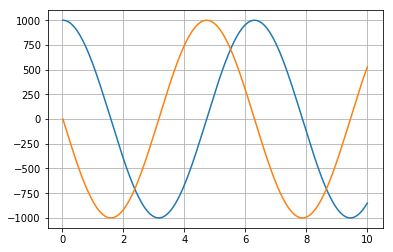

In [20]:
x_l = [qs[i][7] for i in range(len(tn))]
z_l = [qs[i][9] for i in range(len(tn))]
plt.plot(tn,x_l)
plt.plot(tn,z_l)
plt.grid()
plt.show()

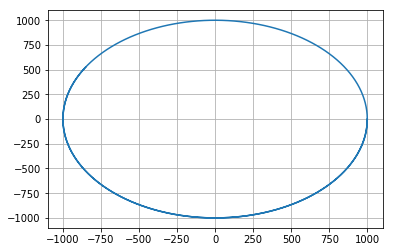

In [20]:
plt.plot(x_l,z_l)
plt.grid()
plt.show()

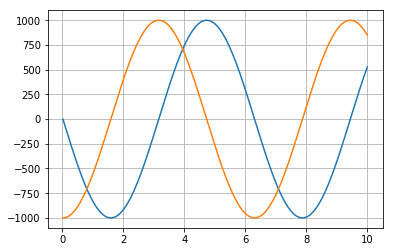

In [21]:
xd_l = [vs[i][7] for i in range(len(tn))]
zd_l = [vs[i][9] for i in range(len(tn))]
plt.plot(tn,xd_l)
plt.plot(tn,zd_l)
plt.grid()
plt.show()

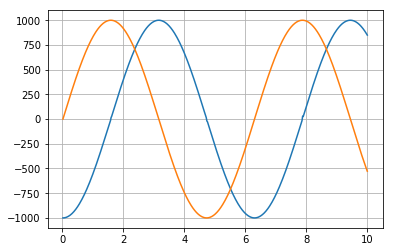

In [22]:
xdd_l = [ass[i][7] for i in range(len(tn))]
zdd_l = [ass[i][9] for i in range(len(tn))]
plt.plot(tn,xdd_l)
plt.plot(tn,zdd_l)
plt.grid()
plt.show()

In [13]:
import pandas as pd 
pd.DataFrame(np.array(jac_f(*qn),dtype=np.float64))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.0,0.0,0.0,-5.411961e+02,1.306563e+03,-5.411961e+02,1.306563e+03
1,0.0,1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-1.0,0.0,-1.306563e+03,5.411961e+02,1.306563e+03,-5.411961e+02
2,0.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,-1.0,-5.411961e+02,-1.306563e+03,5.411961e+02,1.306563e+03
3,0.0,0.0,0.0,3.925231e-17,1.414214e+00,1.962616e-16,1.414214e+00,0.0,0.0,0.0,1.847759e+00,-1.665335e-16,-3.330669e-16,7.653669e-01
4,0.0,0.0,0.0,1.962616e-16,1.414214e+00,-3.925231e-17,-1.414214e+00,0.0,0.0,0.0,3.330669e-16,7.653669e-01,1.847759e+00,1.665335e-16
5,0.0,0.0,0.0,1.678032e-09,7.850462e-17,-2.000000e+00,-7.850462e-17,0.0,0.0,0.0,5.411961e-01,1.306563e+00,-5.411961e-01,-1.306563e+00
6,1.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,0.0,1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,0.0,0.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,0.0,0.0,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
